In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. 데이터 로드

In [2]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [ ]:
train.shape, test.shape, submission.shape
train.head(3)
test.head(3)
submission.head(3)

# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## Target 분포

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

train['voted'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
sns.countplot('voted', data=train, ax=ax[1])

plt.show()

# 균일

## EDA

In [3]:
col_Q_A = []
col_Q_E = []

for f in train.columns:
    if 'Q' in f:
        if 'A' in f:
            col_Q_A.append(f)
        if 'E' in f:
            col_Q_E.append(f)
            

In [ ]:
train[col_Q_A].describe()
train[col_Q_E].describe()

In [4]:
train[col_Q_A].head(3)
train[col_Q_E].head(3)

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,5.0,5.0,2.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0


,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409


### Q_A 1/5 count

In [58]:
train['Q1'] = 0
train['Q5'] = 0

test['Q1'] = 0
test['Q5'] = 0

In [59]:
for f in col_Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q1'] = train.loc[i, 'Q1']+1
        if v == 5:
            train.loc[i, 'Q5'] = train.loc[i, 'Q5']+1            

In [60]:
for f in col_Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q1'] = test.loc[i, 'Q1']+1
        if v == 5:
            test.loc[i, 'Q5'] = test.loc[i, 'Q5']+1            

In [62]:
pd.options.display.max_columns = 80
train

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13,Q1,Q5
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,5.0,539,2.0,586,4.0,1095,5.0,1142,4.0,1287,4.0,883,4.0,851,2.0,851,5.0,816,2.0,579,2.0,924,2.0,366,2.0,876,2.0,633,1.0,1115,30s,2,1,4,Female,1,3,White,Other,2,2,2,1,2,1,7,4,4,3,1,2,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1,2,4
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,3.0,2190,1.0,826,1.0,4082,5.0,1867,3.0,1264,5.0,2943,4.0,3927,1.0,4329,5.0,1828,1.0,1214,5.0,2414,5.0,1356,1.0,3039,4.0,4304,1.0,1346,20s,4,2,3,Female,1,1,Asian,Hindu,1,1,0,0,1,2,3,4,0,4,3,2,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,1,7,8
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,1.0,531,4.0,1167,1.0,1016,3.0,2653,2.0,1569,5.0,998,5.0,2547,2.0,918,4.0,2153,2.0,1304,1.0,1131,5.0,937,4.0,1327,1.0,1170,1.0,1409,30s,3,1,3,Male,1,2,White,Other,2,3,1,5,3,4,2,6,1,3,2,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1,7,4
3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,2.0,1519,4.0,159,3.0,2275,5.0,2809,4.0,5614,3.0,3219,4.0,1296,4.0,9046,4.0,1216,4.0,1169,4.0,23868,3.0,581,4.0,8830,4.0,2392,5.0,1312,20s,4,2,0,Female,1,1,Asian,Hindu,2,4,1,1,1,3,1,3,1,3,3,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,1,2
4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,2.0,628,1.0,991,1.0,1259,5.0,1153,5.0,1388,5.0,740,5.0,1181,4.0,547,2.0,575,1.0,754,4.0,1140,5.0,323,5.0,1070,1.0,583,2.0,1889,20s,3,1,2,Male,1,2,White,Agnostic,1,1,1,6,0,2,0,6,2,6,1,1,0,1,0,1,1,0,1,1,1,1,1,0,1,1,1,1,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,2.0,1050,5.0,619,4.0,328,1.0,285,1.0,602,1.0,267,1.0,315,1.0,483,1.0,1016,4.0,278,4.0,611,5.0,215,4.0,388,1.0,299,2.0,1915,4.0,439,2.0,823,1.0,309,5.0,586,4.0,2252,10s,2,1,1,Female,3,1,White,Jewish,1,2,6,1,2,6,3,0,6,4,3,2,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1,8,3
45528,2.0,581,3.0,1353,4.0,1164,1.0,798,3.0,1680,2.0,560,2.0,640,1.0,1415,2.0,4494,5.0,1392,2.0,2478,5.0,1268,3.0,843,2.0,1401,4.0,1524,4.0,719,2.0,754,3.0,1118,4.0,654,4.0,1197,30s,2,1,2,Male,1,1,White,Atheist,2,2,2,3,1,3,3,4,1,5,1,2,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,2,2
45529,4.0,593,1.0,857,1.0,1047,4.0,1515,5.0,1690,4.0,1253,5.0,1094,1.0,1283,5.0,2209,1.0,1764,5.0,1062,5.0,1489,1.0,1908,4.0,891,1.0,1298,1.0,1200,5.0,473,5.0,1779,3.0,1355,1.0,667,10s,2,1,1,Female,1,1,White,Christian_Other,4,4,2,4,0,1,0,2,1,6,2,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0,1,1,8,7


## Target Encoding

### age_group

In [63]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [64]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [65]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [66]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [67]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [68]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

## Outlier

In [ ]:
test.familysize.max(), test.familysize.mean(), train[train.familysize < 30]['familysize'].mean()

In [ ]:
train[train.familysize > 20][['voted', 'familysize']]

In [69]:
train.loc[train[train.familysize > 25].index, 'familysize'] = 2.6

In [ ]:
train['familysize'].value_counts()

## 인코딩

In [ ]:
#age_group, gender, race, religion
#train['age_group'] = train['age_group'].str.replace('s','').astype('int')
train['gender']= pd.factorize(train['gender'])[0]
train['race']=pd.factorize(train['race'])[0]
train['religion']=pd.factorize(train['religion'])[0]

#test['age_group'] = test['age_group'].str.replace('s','').astype('int')
test['gender']=pd.factorize(test['gender'])[0]
test['race']=pd.factorize(test['race'])[0]
test['religion']=pd.factorize(test['religion'])[0]

### One-hot

In [ ]:
train = pd.get_dummies(train, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
train

In [ ]:
test = pd.get_dummies(test, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
test

In [ ]:
train.shape, test.shape
train.columns.values
test.columns.values

# 3. 모델 학습

In [70]:
from pycaret.classification import *

In [71]:
import gc
gc.collect()

32

In [72]:
col_Q_A.extend(['age_group','gender','race','religion'])
print(col_Q_A)

['QaA', 'QbA', 'QcA', 'QdA', 'QeA', 'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA', 'QrA', 'QsA', 'QtA', 'age_group', 'gender', 'race', 'religion']


In [74]:
%%time
clf = setup(data = train, target = 'voted', polynomial_features=True
            ,categorical_features=col_Q_A
            ,numeric_features=['Q1','Q5']
          #, categorical_features=['age_group','gender','race','religion', col_Q_A]
            #,ignore_features =['age_group_mean_smoothing']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,6418
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45532, 80)"
4,Missing Values,False
5,Numeric Features,24
6,Categorical Features,55
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 35.4 s


In [75]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6948,0.7662,0.6417,0.7626,0.6968,0.3942,0.4002,34.8617
1,CatBoost Classifier,0.6948,0.7669,0.6591,0.7522,0.7025,0.3919,0.3956,21.8065
2,Light Gradient Boosting Machine,0.6921,0.7641,0.6443,0.7567,0.6959,0.3882,0.3935,1.4220
3,Extra Trees Classifier,0.6910,0.7599,0.6378,0.7587,0.6929,0.3865,0.3925,4.7372
4,Linear Discriminant Analysis,0.6909,0.7629,0.6636,0.7437,0.7013,0.3832,0.3860,1.4984
5,Ridge Classifier,0.6908,0.0000,0.6638,0.7434,0.7012,0.3829,0.3856,0.2632
6,Ada Boost Classifier,0.6883,0.7579,0.6524,0.7459,0.6959,0.3792,0.3829,8.0510
7,Extreme Gradient Boosting,0.6746,0.7449,0.6616,0.7205,0.6897,0.3489,0.3504,16.6238
8,Random Forest Classifier,0.6600,0.7161,0.6015,0.7294,0.6592,0.3262,0.3323,0.5138
9,Decision Tree Classifier,0.6132,0.6100,0.6446,0.6469,0.6457,0.2199,0.2199,2.5319


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=6418, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
models()

## turn model

In [79]:
gbc  = create_model('gbc')    
#tuned_gbc = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6876,0.7543,0.6196,0.7643,0.6844,0.3817,0.3900
1,0.6851,0.7625,0.6265,0.7557,0.6851,0.3756,0.3822
2,0.6966,0.7756,0.6383,0.7674,0.6970,0.3982,0.4050
3,0.6991,0.7626,0.6550,0.7612,0.7041,0.4015,0.4062
4,0.7060,0.7696,0.6667,0.7655,0.7127,0.4146,0.4187
5,0.6856,0.7581,0.6305,0.7543,0.6869,0.3762,0.3823
6,0.7063,0.7763,0.6443,0.7804,0.7058,0.4179,0.4256
7,0.6938,0.7682,0.6500,0.7558,0.6990,0.3909,0.3955
8,0.7013,0.7673,0.6535,0.7660,0.7053,0.4063,0.4116
9,0.6869,0.7671,0.6322,0.7553,0.6883,0.3786,0.3847


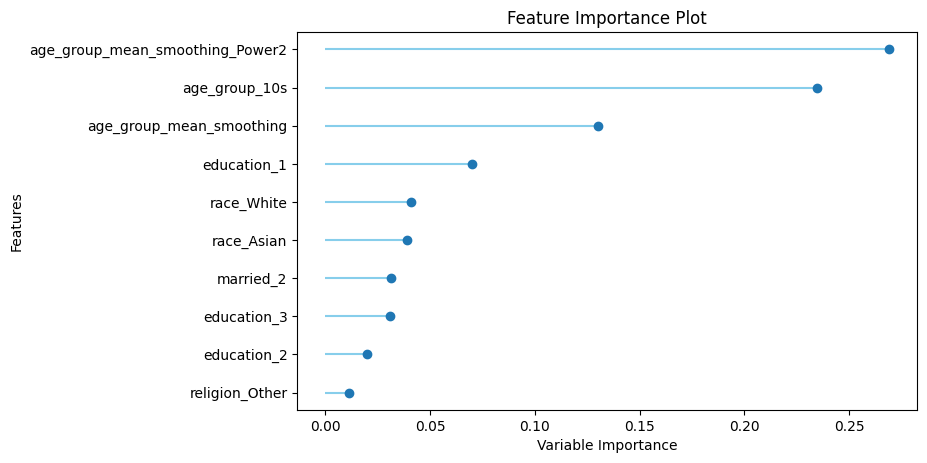

In [80]:
plot_model(estimator = gbc, plot = 'feature')

In [81]:
gc.collect()

2849

In [78]:
lightgbm  = create_model('lightgbm') 
#tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6779,0.7476,0.6443,0.7340,0.6862,0.3581,0.3613
1,0.6863,0.7584,0.6489,0.7446,0.6934,0.3754,0.3791
2,0.6856,0.7636,0.6596,0.7375,0.6964,0.3725,0.3750
3,0.6784,0.7520,0.6470,0.7332,0.6874,0.3589,0.3619
4,0.6831,0.7511,0.6615,0.7330,0.6954,0.3669,0.3690
5,0.6709,0.7396,0.6259,0.7332,0.6753,0.3458,0.3502
6,0.6875,0.7564,0.6437,0.7495,0.6926,0.3785,0.3830
7,0.6878,0.7578,0.6690,0.7361,0.7009,0.3759,0.3778
8,0.6865,0.7586,0.6701,0.7337,0.7004,0.3731,0.3748
9,0.6869,0.7537,0.6517,0.7439,0.6948,0.3761,0.3796


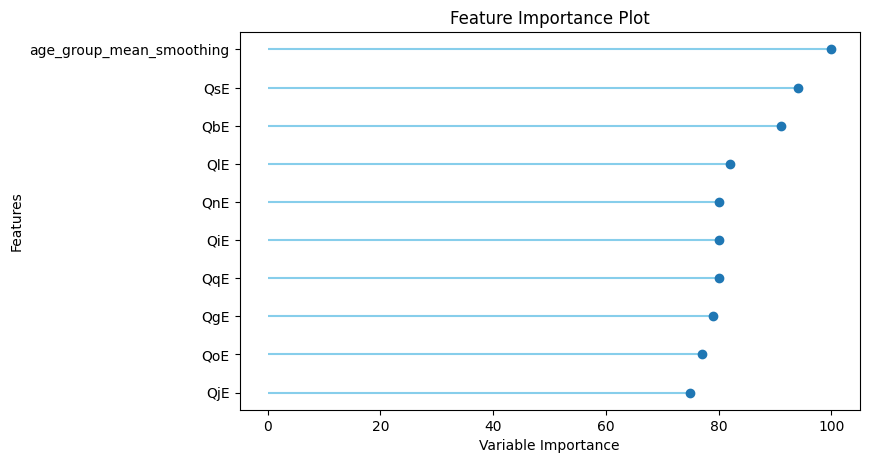

In [82]:
plot_model(estimator = lightgbm, plot = 'feature')

In [83]:
catboost  = create_model('catboost') 
#tuned_catboost = tune_model(catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6920,0.7577,0.6386,0.7597,0.6939,0.3886,0.3945
1,0.6829,0.7620,0.6512,0.7380,0.6919,0.3678,0.3709
2,0.7022,0.7772,0.6619,0.7621,0.7084,0.4072,0.4115
3,0.6981,0.7641,0.6693,0.7513,0.7080,0.3978,0.4006
4,0.7019,0.7724,0.6741,0.7547,0.7121,0.4051,0.4079
5,0.6843,0.7540,0.6397,0.7468,0.6891,0.3724,0.3770
6,0.6988,0.7747,0.6495,0.7643,0.7022,0.4015,0.4070
7,0.6938,0.7679,0.6747,0.7420,0.7067,0.3878,0.3897
8,0.6941,0.7670,0.6690,0.7455,0.7052,0.3892,0.3917
9,0.6997,0.7715,0.6632,0.7575,0.7072,0.4018,0.4056


In [ ]:
best_3 = compare_models(sort = 'AUC', n_select = 3)

In [91]:
best_5 = compare_models(sort = 'AUC', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.6948,0.7669,0.6591,0.7522,0.7025,0.3919,0.3956,21.8100
1,Gradient Boosting Classifier,0.6948,0.7662,0.6417,0.7626,0.6968,0.3942,0.4002,32.7325
2,Light Gradient Boosting Machine,0.6921,0.7641,0.6443,0.7567,0.6959,0.3882,0.3935,1.3272
3,Linear Discriminant Analysis,0.6909,0.7629,0.6636,0.7437,0.7013,0.3832,0.3860,1.4019
4,Extra Trees Classifier,0.6910,0.7599,0.6378,0.7587,0.6929,0.3865,0.3925,4.5454
5,Ada Boost Classifier,0.6883,0.7579,0.6524,0.7459,0.6959,0.3792,0.3829,7.9412
6,Extreme Gradient Boosting,0.6746,0.7449,0.6616,0.7205,0.6897,0.3489,0.3504,16.4847
7,Random Forest Classifier,0.6600,0.7161,0.6015,0.7294,0.6592,0.3262,0.3323,0.5677
8,Decision Tree Classifier,0.6132,0.6100,0.6446,0.6469,0.6457,0.2199,0.2199,2.5460
9,K Neighbors Classifier,0.5172,0.5135,0.5864,0.5554,0.5704,0.0201,0.0202,2.7235


In [92]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6856,0.7601,0.6302,0.7545,0.6868,0.3763,0.3825
1,0.7023,0.7743,0.6609,0.7629,0.7083,0.4075,0.4118
2,0.6931,0.7651,0.6582,0.7499,0.7011,0.3886,0.3920
3,0.7013,0.7745,0.6568,0.7638,0.7063,0.4059,0.4107
4,0.6974,0.7729,0.6578,0.7570,0.7039,0.3975,0.4016
Mean,0.6959,0.7694,0.6528,0.7576,0.7013,0.3952,0.3997
SD,0.0061,0.0058,0.0114,0.0052,0.0076,0.0116,0.0112


In [93]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6958,0.7663,0.6456,0.7618,0.6989,0.3958,0.4013


In [94]:
final_model = finalize_model(blended)

In [95]:
predictions = predict_model(final_model, data = test)

In [96]:
submission['voted'] = predictions['Score']

In [97]:
submission.to_csv('output/20200929-3.csv')

In [84]:
best_3 = [gbc, lightgbm, catboost]

In [ ]:
turns = [tuned_gbc, tuned_lightgbm, tuned_catboost]#, tuned_ridge]

In [85]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')
#blended = blend_models(estimator_list = turns, fold = 5, optimize='AUC', method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6864,0.7586,0.6279,0.7572,0.6865,0.3783,0.3849
1,0.6996,0.7727,0.6535,0.7631,0.7041,0.4028,0.4078
2,0.6936,0.7653,0.6531,0.7536,0.6998,0.3902,0.3944
3,0.7033,0.7740,0.6577,0.7666,0.7080,0.4101,0.4150
4,0.6981,0.7721,0.6523,0.7616,0.7027,0.3998,0.4048
Mean,0.6962,0.7685,0.6489,0.7604,0.7002,0.3962,0.4014
SD,0.0058,0.0058,0.0106,0.0045,0.0073,0.0110,0.0106


In [86]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6944,0.7657,0.6414,0.7622,0.6966,0.3934,0.3994


In [87]:
final_model = finalize_model(blended)

In [ ]:
final_model

In [88]:
predictions = predict_model(final_model, data = test)

In [89]:
submission['voted'] = predictions['Score']

In [90]:
submission.to_csv('output/20200929-3.csv')

## train, valid 데이터

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('voted', axis = 1), train['voted'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

## 하이퍼파라미터 튜닝

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, plot_importance

colsample_bytree': 0.9606396547156734
, 'max_bin': 164.7465545875555
, 'max_depth': 11.107229265820779
, 'min_child_samples': 198.98606348612637
, 'min_child_weight': 41.32364031573033
, 'num_leaves': 49.45519154750152
, 'reg_alpha': 0.8758415725587487
, 'reg_lambda': 8.299355787002883
, 'subsample': 0.6598579157665245}}

In [ ]:
# parameter 별로 search할 범위를 설정. 
bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (10, 100), 
    'min_child_samples': (10, 500), 
    'min_child_weight':(1, 100),
    'subsample':(0.1, 1.0),
    'colsample_bytree': (0.1, 1.0),
    'max_bin':(10, 1000),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

In [ ]:
def lgb_roc_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        #"n_estimators":500, "learning_rate":0.02,
        "n_estimators":1000, "learning_rate":0.001,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    valid_proba = lgb_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, valid_proba)
    
    return roc_auc   

In [ ]:
import gc
gc.collect()

In [ ]:
%%time
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_roc_eval,bayesian_params , random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=10, n_iter=50)

In [ ]:
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

* test_size=0.3
{'target': 0.7655615473679408, 'params': {'colsample_bytree': 0.737265320016441, 'max_bin': 30.378649352844423, 'max_depth': 15.699098521619943, 'min_child_samples': 417.8968939922066, 'min_child_weight': 22.02157195714934, 'num_leaves': 26.364247048639054, 'reg_alpha': 9.178391447573157, 'reg_lambda': 3.043118187352418, 'subsample': 0.5722807884690141}}

- outlier 삭제 
{'target': 0.7652209584768751, 'params': {'colsample_bytree': 0.5703824815639528, 'max_bin': 15.404309116854074, 'max_depth': 13.17919661428763, 'min_child_samples': 24.998278489695448, 'min_child_weight': 97.74061068693372, 'num_leaves': 99.35614131954165, 'reg_alpha': 1.2926370490809749, 'reg_lambda': 1.1059679925299122, 'subsample': 0.4274854420066033}}

- outlier 2.6 
{'target': 0.7655617202045278, 'params': {'colsample_bytree': 0.737265320016441, 'max_bin': 30.378649352844423, 'max_depth': 15.699098521619943, 'min_child_samples': 417.8968939922066, 'min_child_weight': 22.02157195714934, 'num_leaves': 26.364247048639054, 'reg_alpha': 9.178391447573157, 'reg_lambda': 3.043118187352418, 'subsample': 0.5722807884690141}}

In [ ]:
clf = LGBMClassifier(
        n_jobs=-1
        ,nthread=4
        ,n_estimators=1000
        ,learning_rate=0.02
        ,max_depth = 16
        ,num_leaves=47
        ,colsample_bytree=0.56
        ,subsample=0.55
        ,max_bin=30
        ,reg_alpha=0.23
        ,reg_lambda=0.03
        ,min_child_weight=70
        ,min_child_samples=169
        ,silent=-1
        ,verbose=-1
        ,random_state=42
        )

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
eval_metric= 'auc', verbose= 100, early_stopping_rounds= 50)

In [ ]:
plot_importance(clf, figsize=(16, 32))

# 4. 예측

In [ ]:
pred_y  = clf.predict(test)

In [ ]:
submission['voted'] = pred_y 

In [ ]:
submission

# 5. 제출

In [ ]:
submission.to_csv('output/20200928-1.csv')